In [10]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

In [11]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_usage = {}

    def gini_impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def calculate_gini(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature_idx in range(X.shape[1]):
            sorted_indices = np.argsort(X[:, feature_idx])

            sorted_X = X[sorted_indices]
            sorted_y = y[sorted_indices]

            for i in range(1, len(sorted_X)):
                threshold = (sorted_X[i - 1, feature_idx] + sorted_X[i, feature_idx]) / 2  # Midpoint between consecutive values
                left_indices = []
                right_indices = []

                for idx, value in enumerate(sorted_X[:,feature_idx]):
                    if value <= threshold:
                        left_indices.append(idx)
                    else:
                        right_indices.append(idx)

                left_indices = np.array(left_indices)
                right_indices = np.array(right_indices)

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                left_impurity = self.gini_impurity(sorted_y[left_indices])
                right_impurity = self.gini_impurity(sorted_y[right_indices])

                weighted_left_impurity = len(sorted_y[left_indices]) * left_impurity
                weighted_right_impurity = len(sorted_y[right_indices]) * right_impurity

                impurity = (weighted_left_impurity + weighted_right_impurity) / len(sorted_y)

                if impurity < best_gini:
                    best_gini = impurity
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gini
    
    def most_freq_label(self, y):
        counts = np.bincount(y)
        return np.argmax(counts)

    def build_tree(self, X, y, depth=0):

        if len(np.unique(y)) == 1:
            return Node(label=y[0])
        
        elif depth >= self.max_depth:
            most_frequent_label = self.most_freq_label(y)
            return Node(label=most_frequent_label)
        
        elif len(y) < self.min_samples_split:
            most_frequent_label = self.most_freq_label(y)
            return Node(label=most_frequent_label)

        best_feature, best_threshold, best_gini = self.calculate_gini(X, y)

        if best_gini == float('inf'):
            most_frequent_label = self.most_freq_label(y)
            return Node(label=most_frequent_label)
        
        if best_feature in self.feature_usage:
            self.feature_usage[best_feature] += 1
        else:
            self.feature_usage[best_feature] = 1

        left_indices = []
        right_indices = []

        for idx, value in enumerate(X[:, best_feature]):
            if value <= best_threshold:
                left_indices.append(idx)  # Assign to left group
            else:
                right_indices.append(idx)

        left_indices = np.array(left_indices)
        right_indices = np.array(right_indices)

        left_node = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_node = self.build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_node, right=right_node, label=None)

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_sample(self, sample, node):
        if node.label is not None:
            return node.label
        if sample[node.feature] <= node.threshold:
            return self.predict_sample(sample, node.left)
        else:
            return self.predict_sample(sample, node.right)

    def cal_accuracy(self, predicted_labels, test_labels):
        predicted_labels = np.array(predicted_labels)
        test_labels = np.array(test_labels)
        
        correct_count = 0
        
        for predicted, actual in zip(predicted_labels, test_labels):
            if predicted == actual:
                correct_count += 1

        return correct_count / len(test_labels)
    
    def print_tree(self, node=None, depth=0, prefix="Root"):
        """Recursively prints the tree in a structured tree format."""
        if node is None:
            node = self.tree
        
        indent = "    " * depth
        
        if node.label is not None:
            print(f"{indent}└── [Leaf] Class: {node.label}")
            return
        
        print(f"{indent}└── {prefix} Feature {node.feature} <= {node.threshold:.2f}")
        
        self.print_tree(node.left, depth + 1, "Left")
        
        self.print_tree(node.right, depth + 1, "Right")


    def plot_feature_usage(self):
        """Plots the frequency of each feature's usage in tree splits."""
        features = list(self.feature_usage.keys())
        counts = list(self.feature_usage.values())
        
        # Sort the features based on their usage frequency
        sorted_indices = np.argsort(counts)[::-1]
        features_sorted = [features[i] for i in sorted_indices]
        counts_sorted = [counts[i] for i in sorted_indices]
        
        # Plot the bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(features_sorted, counts_sorted, color='skyblue')
        plt.xlabel('Feature Index')
        plt.ylabel('Usage Frequency')
        plt.title('Feature Usage in Decision Tree Splits')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

In [12]:
train_features = pd.read_csv('train_features.csv').values
train_labels = pd.read_csv('train_label.csv').values.flatten()
test_features = pd.read_csv('test_features.csv').values
test_labels = pd.read_csv('test_label.csv').values.flatten()
val_features = pd.read_csv('val_features.csv').values
val_labels = pd.read_csv('val_label.csv').values

In [13]:
clf = DecisionTree(max_depth=7, min_samples_split=3)

clf.fit(train_features, train_labels)

predicted_labels_train = [clf.predict_sample(sample, clf.tree) for sample in train_features]

predicted_labels_val = [clf.predict_sample(sample, clf.tree) for sample in val_features]

predicted_labels_test = [clf.predict_sample(sample, clf.tree) for sample in test_features]

accuracy_train = clf.cal_accuracy(predicted_labels_train, train_labels)
accuracy_val = clf.cal_accuracy(predicted_labels_val, val_labels)
accuracy_test = clf.cal_accuracy(predicted_labels_test, test_labels)

print(f"The accuracy for train_Data is {accuracy_train}")
print(f"The accuracy for val_Data is {accuracy_val}")
print(f"The accuracy for test_Data is {accuracy_test}")

The accuracy for train_Data is 0.9080472458328734
The accuracy for val_Data is 0.6066225165562914
The accuracy for test_Data is 0.5888378664782762


In [14]:
clf.print_tree()

└── Root Feature 5 <= -0.03
    └── Left Feature 8 <= -0.18
        └── [Leaf] Class: 1
        └── Right Feature 8 <= 0.18
            └── Left Feature 3 <= -0.10
                └── Left Feature 2 <= -0.21
                    └── Left Feature 0 <= -0.19
                        └── Left Feature 6 <= -0.04
                            └── [Leaf] Class: 1
                            └── [Leaf] Class: 0
                        └── Right Feature 3 <= -0.10
                            └── [Leaf] Class: 0
                            └── [Leaf] Class: 1
                    └── Right Feature 0 <= 0.86
                        └── Left Feature 4 <= -0.09
                            └── [Leaf] Class: 0
                            └── [Leaf] Class: 1
                        └── Right Feature 5 <= -0.04
                            └── [Leaf] Class: 0
                            └── [Leaf] Class: 1
                └── Right Feature 9 <= -0.01
                    └── [Leaf] Class: 1
                 

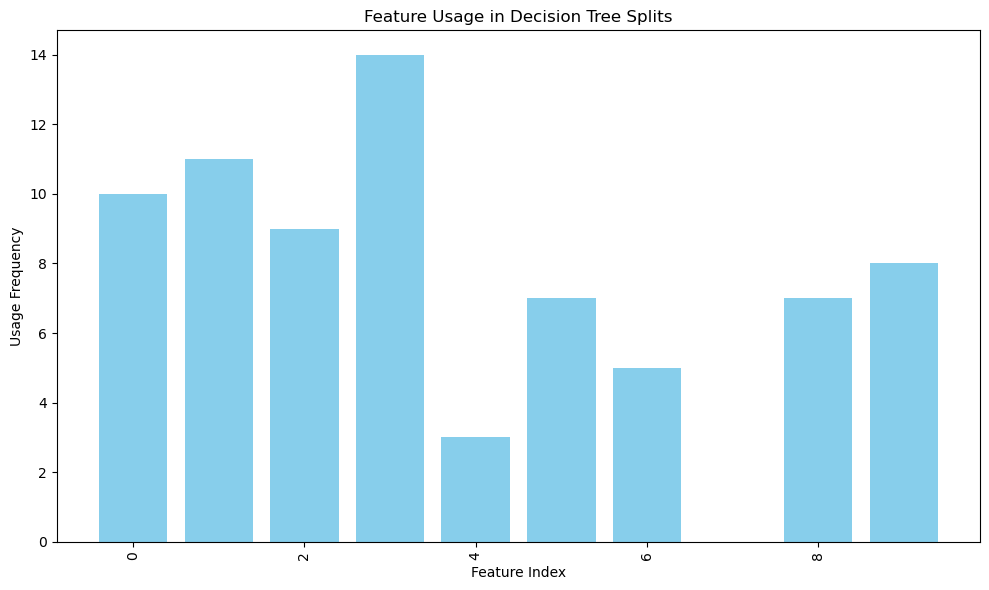

In [15]:
clf.plot_feature_usage()

In [16]:
sklearn_tree = DecisionTreeClassifier(max_depth=7, min_samples_split=3, criterion="gini", random_state=42)
sklearn_tree.fit(train_features, train_labels)

sklearn_train_acc = sklearn_tree.score(train_features, train_labels)
sklearn_val_acc = sklearn_tree.score(val_features, val_labels)
sklearn_test_acc = sklearn_tree.score(test_features, test_labels)

print(f"The accuracy for train_Data is {sklearn_train_acc}")
print(f"The accuracy for val_Data is {sklearn_val_acc}")
print(f"The accuracy for test_Data is {sklearn_test_acc}")

The accuracy for train_Data is 0.9039629098134452
The accuracy for val_Data is 0.6163355408388521
The accuracy for test_Data is 0.6026139173436948


In [17]:
param_grid = [(3, 10), (5, 3), (6, 4), (8, 5), (9, 10), (10, 6), (11, 3)]

3 10
5 3
6 4
8 5
9 10
10 6
11 3


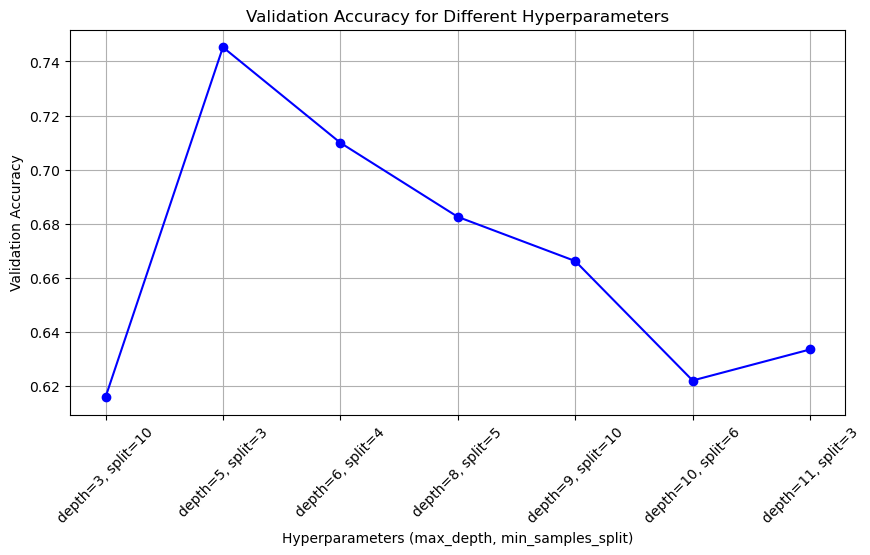

In [18]:
accuracies = []
params = []

for max_depth, min_samples_split in param_grid:
    print(max_depth, min_samples_split)
    clf = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split)
    clf.fit(train_features, train_labels)
    
    predicted_labels_val = [clf.predict_sample(sample, clf.tree) for sample in val_features]
    
    accuracy_val = clf.cal_accuracy(predicted_labels_val, val_labels)
    
    accuracies.append(accuracy_val)
    params.append(f"depth={max_depth}, split={min_samples_split}")

plt.figure(figsize=(10, 5))
plt.plot(params, accuracies, marker='o', linestyle='-', color='b')
plt.xticks(rotation=45)
plt.xlabel("Hyperparameters (max_depth, min_samples_split)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Hyperparameters")
plt.grid()
plt.show()